# MNIST Conditional Generative Adversarial Networks
Implementation of vanilla Conditional GAN on MNIST dataset.

#### Losses
* Discriminator Loss
* Generator Loss

The discriminator will induce the generator to produce samples similar to the real samples but conditioned on a specific class.

#### Changes
In order to make the GAN conditioned you need to concatenate the label (one-hot or embedding) on the Generator random signal, and on the discriminator input.

#### References
* [Paper](https://arxiv.org/pdf/1411.1784.pdf)
* [Tensorflow Code](http://i-systems.github.io/HSE545/iAI/DL/topics/09_GAN/02_CGAN.html)
* [Various GAN Implementation on Pytorch](https://github.com/eriklindernoren/PyTorch-GAN)
* [GAN Hacks](https://github.com/soumith/ganhacks)
* [Clone and Detach](https://discuss.pytorch.org/t/clone-and-detach-in-v0-4-0/16861/2)

In [1]:
import mnist_data_pytorch as data
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import numpy as np
from tqdm import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Pytorch version:', torch.__version__)
# Tensorboard
from torch.utils.tensorboard import SummaryWriter
!rm -rf ./runs
writer = SummaryWriter('./runs/train')

# Metaparameters
num_epochs = 100
num_classes = 10
latent_size = 64
gen_lr = 0.0002
disc_lr = 0.0002
EPS = 1e-15

Device: cuda:0
Pytorch version: 1.2.0


#### Function to convert to One-Hot

In [2]:
def one_hot(labels, num_classes=10):
    """
    Convert labels to one_hot_encoding
    """
    # Convert to One Hot Encoding
    y = torch.eye(num_classes)
    return y[labels]

print('1: one-hot', one_hot(1))
print('9: one-hot', one_hot(9))

1: one-hot tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
9: one-hot tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])


#### Define Encoder/Decoder/Discriminator

In [3]:
class Generator(nn.Module):
    def __init__(self, latent_size=100, output_size=784, num_classes=10):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_size + num_classes, 256, normalize=False),
            *block(256, 256),
            nn.Linear(256, output_size),
            #nn.Tanh()
            nn.Sigmoid() #Sigmoid bit better for MNIST
        )

    def forward(self, z, y):
        # Concatenate labels(one-hot) to Z
        # We could also use nn.embedding to make the labels conversion
        x = torch.cat((y, z), 1)
        x = self.model(x)
        return x


class Discriminator(nn.Module):
    def __init__(self, input_size=784, num_classes=10):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_size + num_classes, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, y):
        # Concatenate labels(one-hot) to X (real, or generated)
        # We could also use nn.embedding to make the labels conversion
        x = torch.cat((y, x), 1)
        real_or_fake = self.model(x)
        return real_or_fake

# Initialize Networks
G = Generator(output_size=784, latent_size=latent_size).to(device)
D = Discriminator(input_size=784).to(device)

#### Initialize Optimizers

In [4]:
optim_generator = torch.optim.Adam(G.parameters(), lr=gen_lr)
optim_discriminator = torch.optim.Adam(D.parameters(), lr=disc_lr)

#### Train loop

In [5]:
k = 1
for epoch in tqdm(range(num_epochs)):
    running_loss_G = 0.0
    running_loss_D = 0.0
    # Iterate over the data
    for idx_sample, (real_imgs, labels) in enumerate(data.dataloaders['train']):
        real_imgs = real_imgs.to(device)
        real_imgs = torch.flatten(real_imgs, start_dim=1, end_dim=-1)
        labels = labels.to(device)
        # Convert y to one-hot and send to GPU
        y = one_hot(labels)
        y = y.to(device)
        batch_size = real_imgs.size()[0]
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        for _ in range(k):
            # Adversarial ground truths (you can do soft-label here....)
            valid = (torch.ones(batch_size, 1).fill_(1.0)).to(device)
            fake = (torch.ones(batch_size, 1).fill_(0.0)).to(device)
            
            z_sample = torch.randn(batch_size, latent_size).to(device)

            # Detach will make a copy and take the tensor out of the backprop graph.
            gen_samples = G(z_sample,y).detach()
            
            optim_discriminator.zero_grad()
            # Measure discriminator's ability to classify real from generated samples
            real_loss = F.binary_cross_entropy(D(real_imgs, y), valid)
            fake_loss = F.binary_cross_entropy(D(gen_samples, y), fake)
            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optim_discriminator.step()
        
        # ---------------------
        #  Train Generator
        # ---------------------
        optim_generator.zero_grad()
        # Sample from distribution Z (z~Z)
        z_sample = torch.randn(batch_size, latent_size).to(device)

        # Loss measures generator's ability to fool the discriminator
        gen_samples = G(z_sample, y)
        g_loss = F.binary_cross_entropy(D(gen_samples, y), valid)

        g_loss.backward()
        optim_generator.step()
        
        # Update statistics
        running_loss_G += g_loss.item() * batch_size
        # Update statistics
        running_loss_D += d_loss.item() * batch_size
    
    # Epoch ends
    epoch_loss_generator = running_loss_G / len(data.dataloaders['train'].dataset)
    epoch_loss_discriminator = running_loss_D / len(data.dataloaders['train'].dataset)
    
    # Send results to tensorboard
    writer.add_scalar('train/loss_generator', epoch_loss_generator, epoch)
    writer.add_scalar('train/loss_discriminator', epoch_loss_discriminator, epoch)
    
    # Send images to tensorboard
    writer.add_images('train/gen_samples', gen_samples.view(batch_size,1,28,28), epoch)
    writer.add_images('train/input_images', real_imgs.view(batch_size,1,28,28), epoch)
    
    # Send latent to tensorboard
    writer.add_histogram('train/latent', z_sample, epoch)
    writer.add_histogram('train/X', real_imgs, epoch)
    writer.add_histogram('train/G(z)', gen_samples, epoch)

100%|██████████| 100/100 [09:25<00:00,  5.66s/it]


#### Generate Samples (Unconditioned)
Observe that the generated samples are somehow a mix of all classes.

In [6]:
def generate_sample(num_idx=0, category=0):
    G.eval()
    y = one_hot([category]).to(device)
    z = torch.randn(1, latent_size).to(device)
    with torch.no_grad(): 
        generated_sample = G(z,y)

    plt.imshow(generated_sample.view(28,28).cpu().numpy())
    plt.title('Generated sample')
    plt.show()

In [8]:
interact(generate_sample, num_idx=widgets.IntSlider(min=0, max=100, step=1, value=0), category = [x for x in range(10)]);

interactive(children=(IntSlider(value=0, description='num_idx'), Dropdown(description='category', options=(0, …

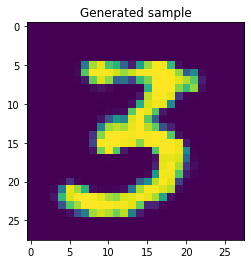

In [10]:
generate_sample(0,3)

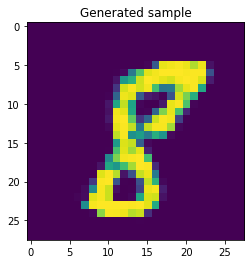

In [11]:
generate_sample(0,8)